# PrefixSpan

In [24]:
import copy
from collections import defaultdict

In [25]:
def projectSequence(sequence, prefix, newEvent):
    result = None
    for i, itemset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in itemset for x in prefix)):
                    result = [list(itemset)]
        else:
            result.append(copy.copy(itemset))
    return result

In [26]:
def projectDatabase(dataset, prefix, newEvent):
    projectedDB = []
    for sequence in dataset:
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

In [27]:
def generateItems(dataset):
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for itemset in sequence:
            if all(x in itemset for x in prefix):
                for item in itemset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

In [28]:
def prefixSpan(dataset, minSupport):
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in itemCounts:
        if count >= minSupport:
            newPrefix = [[item]]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minSupport, newPrefix))
    return result

def prefixSpanInternal(dataset, minSupport, prevPrefixes=[]):
    result = []
    
    # Add a new item to the last element (==same time)
    itemCountSameEvent = generateItemSupports(dataset, False, prefix=prevPrefixes[-1])
    for item, count in itemCountSameEvent:
        if (count >= minSupport) and item > prevPrefixes[-1][-1]:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix[-1].append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, newPrefix[-1], False), minSupport, newPrefix))
        
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minSupport:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append([item])
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minSupport, newPrefix))
    return result

# Load Data

### trade_new.csv

In [51]:
import numpy as np
import pandas as pd
with open('./trade_new.csv', 'r') as resourse_data:
    data = pd.read_csv(resourse_data)[['vipno', 'sldatime', 'pluno', 'dptno', 'bndno']]
data['sldatime'] = pd.to_datetime(data['sldatime'])
sort_data = data.sort_values(['sldatime'],ascending=True).groupby(['vipno', 'sldatime'])


In [50]:
sort_data2 = data.sort_values(['sldatime'],ascending=True).groupby('vipno')
pluno_sequence = []
dptno_sequence = []
bndno_sequence = []
for x in sort_data2:
    pluno_slice = []
    dptno_slice = []
    bndno_slice = []
    length = int(len(x[1])*0.6)
    x2 = x[1].head(length).groupby('sldatime')
    
    for x3 in x2:
        plu_temp = list(x3[1]['pluno'])
        pluno_slice.append(plu_temp)
        dpt_temp = list(x3[1]['dptno'])
        dptno_slice.append(dpt_temp)
        bnd_temp = list(x3[1]['bndno'].dropna().astype(int))
        bndno_slice.append(bnd_temp)
    pluno_sequence.append(pluno_slice)
    dptno_sequence.append(dptno_slice)
    
    while [] in bndno_slice:
        bndno_slice.remove([])
    bndno_sequence.append(bndno_slice)
while [] in bndno_sequence:
    bndno_sequence.remove([])

In [34]:
import matplotlib.pyplot as plt
def get_runtime(support, data):
    temp = []
    for i in support:
        start = time.clock()
        prefixSpan(data, i)
        end = time.clock()
        temp.append(end - start)
    return temp
    
def time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, y):
    n_groups = len(support)

    fig, ax = plt.subplots()    
    index = np.arange(n_groups)    
    bar_width = 0.3  
         
    opacity = 0.4    
    rects1 = plt.bar(index, pluno_runtime, bar_width,alpha=opacity, color='k',label='pluno')    
    rects2 = plt.bar(index + bar_width, dptno_runtime, bar_width,alpha=opacity,color='b',label='dptno')    
    rects2 = plt.bar(index + bar_width * 2, bndno_runtime, bar_width,alpha=opacity,color='c',label='bndno')    

    plt.xlabel('Support')    
    plt.ylabel('Time')    
    plt.title('Time by support and itemno')    
    plt.xticks(index + bar_width, support)    
    plt.ylim(0, y);    
    plt.legend();    
      
    plt.tight_layout();   
    plt.show();

In [22]:
import time
pluno_runtime = []
dptno_runtime = []
bndno_runtime = []
support = [2, 4, 6, 8, 10]

In [29]:
pluno_runtime = get_runtime(support, pluno_sequence)
dptno_runtime = get_runtime(support, dptno_sequence)
bndno_runtime = get_runtime(support, bndno_sequence)

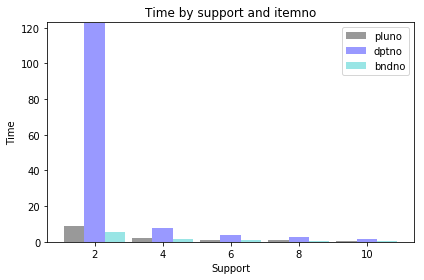

In [43]:
time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, 123)

### trade.csv

In [47]:
with open('./trade.csv', 'r') as resourse_data2:
    data2 = pd.read_csv(resourse_data2)[['vipno', 'sldat', 'pluno', 'dptno', 'bndno']]
data2['sldat'] = pd.to_datetime(data2['sldat'])
sort_data = data2.sort_values(['sldat'],ascending=True).groupby('vipno')
pluno_sequence2 = []
dptno_sequence2 = []
bndno_sequence2 = []
for x in sort_data:
    pluno_slice2 = []
    dptno_slice2 = []
    bndno_slice2 = []
    length = int(len(x[1])*0.6)
    x2 = x[1].head(length).groupby('sldat')
    
    for x3 in x2:
#         print(x3)
#         print('\n')
        plu_temp = list(x3[1]['pluno'])
        pluno_slice2.append(plu_temp)
        dpt_temp = list(x3[1]['dptno'])
        dptno_slice2.append(dpt_temp)
#         print(dpt_temp)
        bnd_temp = list(x3[1]['bndno'].dropna().astype(int))
        bndno_slice2.append(bnd_temp)
#         print(bnd_temp)
#     print("\n")
#     print(pluno_slice)
    pluno_sequence2.append(pluno_slice2)
    dptno_sequence2.append(dptno_slice2)
    
    while [] in bndno_slice2:
        bndno_slice2.remove([])
    bndno_sequence2.append(bndno_slice2)
while [] in bndno_sequence2:
    bndno_sequence2.remove([])

In [39]:
pluno_runtime2 = get_runtime(support, pluno_sequence2)
dptno_runtime2 = get_runtime(support, dptno_sequence2)
bndno_runtime2 = get_runtime(support, bndno_sequence2)

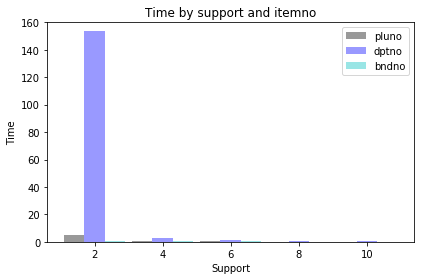

In [42]:
time_table(support, pluno_runtime2, dptno_runtime2, bndno_runtime2, 160)